<a href="https://colab.research.google.com/github/AmadoMaria/hands-on-supercomputing-with-parallel-computing/blob/master/Maria_Amado_e_Fernanda_Lisboa_report_handson_2_jupyter_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On 2: Parallelization with OpenMP

M. Amado$^1$, F. Lisboa$^1$

$^1$ Department of Computer Engenier – University SENAI CIMATEC, Salvador, Bahia, Brazil  

# Abstract

Uma das aplicações do calculo integral é o processamento de imagens, como na aplicação de filtros. A programação paralela pode ser aplicada na execução desses cálculos como uma estratégia de redução do tempo do algoritmo construído. Sendo assim, o objetivo dessa atividade é a utilização dessa ferramenta, por meio da biblioteca OpenMP, visando a redução do tempo de execução de algoritmos que envolvem o cálculo de problemas matemáticos simples (para números pequenos) e demorados para valores maiores em um PC. Nem sempre percebeu-se uma redução significativa ddo tempo de acordo com o aumento do número de threads, o que pode ser atrelado à instabilidade de execução em um PC ou à combinação dos trechos de paralelização no código. Isso leva à conclusão que, dependendo da maneira que é paralelizado, nem sempre o tempo de execução pela quantidade de threads paralelizadas serão inversamente proporcionais, chegando a algumas vezes apresentarem curvas cíclicas ou parabólicas.

# Introduction

O processo de integração retangular de uma função f(x) consiste na representação de f(x) a partir de retângulos que acompanham a curva e obtenção da área de f(x) a partir da soma sucessiva das áreas dos retângulos [1]. Dessa forma, a precisão do cálculo da integral está diretamente relacionada com o número de retângulos utilizados na representação de f(x). Contudo, quanto maior o número de retângulos utiolizados, maior o custo computacional para a execução de um algoritmo capaz de obter o resultado da integral.

Assim, a programação paralela pode ser aplicada no cálculo integral como uma estratégia para redução do tempo de execução do algoritmo, sendo uma das alternativas a utilização do OpenMp para paralelização do código.

Uma das aplicações dessa abordagem do cálculo integral é o processamento de imagens, que pode envolver a supressão ou extração de conteúdo a apartir da aplicação de filtros, como o Gaussiano ou Laplaciano [2]. Assim, na prática, objetivamos a exploração do código de um processamento de imagens sequencial, identificando quais partes podem ocorrer de forma paralela, para uma melhor otimização.

Além dessas aplicações, outro problema que pode ser solucionado mais rápido a partir do paralelismo é verificar se um número é primo. Contudo, nesse caso, o paralelismo vai além de informar se um loop deve ser executado em paralelo.

Dessa forma, o objetivo dessa atividade é realizar a aplicação da paralelização do código para a resolução de problemas matemáticos simples (para valores pequenos), utilizando o a biblioteca OpenMP.




# Results and Discussion

### Session 1 - Numerical Integration

Nessa sessão trabalhou-se com a paralelização de um código que calcula a integral de 0 a 1 do retângulo, cujo tamanho é passado como entrada na execução do programa.

Realizou a paralelização com o uso do reduction e necessitou da redução do número de passos (STEPS).

<!-- ```c
  #pragma omp paralllel for reduction(+: s)
   for (i = 0; i < n; i++)
   {
      s += f(a + h * (i + 0.5));
   }
``` -->



código

In [1]:
!sudo apt install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (154 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
deb

In [ ]:
%%writefile integral.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

/* f(x) function from which the integral will be calculated. */
double f(double x)
{
 return 100 * x + sin(2 * x * M_PI);
}

/* Calculates the integral of the function betweens point a and b. */
double integral(double a, double b, int n)
{
   double h, s = 0, result;
   int i;

   h = (b - a) / n;

   #pragma omp paralllel for reduction(+: s)
   for (i = 0; i < n; i++)
   {
      s += f(a + h * (i + 0.5));
   }

   result = h * s;
   return result;
}

int main(int argc, char *argv[])
{
   float result;

   int steps = atoi(argv[1]);
   
   #pragma omp critical
   result = integral(0, 1, steps);
  
   printf("%f\n", result);

   return 0;
}

In [ ]:
!gcc integral.c -o integral -fopenmp -lc

código

In [ ]:
%%writefile script.sh
#!/bin/sh
for j in $(seq 1 6)
do 
 printf "threads:$j :\n"
 for i in {1000..10000..1000}
 do
  printf "$i - "
   OMP_NUM_THREADS=$j	./integral "$i"
  done
done

E: Invalid operation OpenMP


In [ ]:
!bash script.sh

### Session 2 - Image Processing

Nessa etapa trabalhou-se com um código que realiza a aplicação de um filtro em uma imagem através de convolução.
A análise dos loops que realização as multiplicações de matrizes pertinentes à imagem mostrou:


*   A interdependência dos laços;
*   






In [ ]:
%%writefile image.c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <omp.h>
#define max(a, b) ((a) > (b) ? (a) : (b))
#define min(a, b) ((a) < (b) ? (a) : (b))
#define MAXCAD 100

#define NUM_STEPS 2
#define RADIUS 8
#define INPUT_IMAGE "lenna.ppm"
#define OUTPUT_IMAGE "lenna-fil.ppm"

struct pixel
{
  unsigned char r, g, b;
};

int read_ppm_image(char *file_name, struct pixel ***img, int *out_width, int *out_height)
{
  FILE *fd;
  char type[MAXCAD];
  int rgb_max, actual_width, actual_height, i, j;

  fd = fopen(file_name, "r");
  if (fd == NULL)
  {
    printf("failed opening file %s\n", file_name);
    return -1;
  }

  fscanf(fd, "%s", type);
  if (strcmp(type, "P3") != 0)
  {
    printf("wrong format. P3 format expected\n");
    return -1;
  }

  fscanf(fd, "%d%d", &actual_width, &actual_height);

  if ((*img = (struct pixel **)malloc(sizeof(struct pixel *) * actual_height)) == NULL)
  {
    printf("failed allocating memory for %d rows\n", actual_height);
    return -1;
  }
  if (((*img)[0] = (struct pixel *)malloc(sizeof(struct pixel) * actual_width * actual_height)) == NULL)
  {
    printf("failed de locating memory for %d * %d pixels\n", actual_width, actual_height);
    return -1;
  }
  for (i = 1; i < actual_height; i++)
    (*img)[i] = (*img)[i - 1] + actual_width;

  fscanf(fd, "%d", &rgb_max);

  for (i = 0; i < actual_height; i++)
    for (j = 0; j < actual_width; j++)
    {
      fscanf(fd, "%hhu", &((*img)[i][j].r));
      fscanf(fd, "%hhu", &((*img)[i][j].g));
      fscanf(fd, "%hhu", &((*img)[i][j].b));
    }

  *out_width = actual_height;
  *out_height = actual_width;

  fclose(fd);

  return 0;
}

int write_ppm_image(char *file_name, struct pixel **img, int width, int height)
{
  FILE *fd;
  int rgb_max = 255, i, j;

  fd = fopen(file_name, "w");
  if (fd == NULL)
  {
    printf("failed opening file %s\n", file_name);
    return -1;
  }

  fprintf(fd, "P3\n");
  fprintf(fd, "%d %d\n", height, width);
  fprintf(fd, "%d\n", rgb_max);

  for (i = 0; i < width; i++)
  {
    for (j = 0; j < height; j++)
    {
      fprintf(fd, "%d ", img[i][j].r);
      fprintf(fd, "%d ", img[i][j].g);
      fprintf(fd, "%d ", img[i][j].b);
    }
    fprintf(fd, "\n");
  }

  fclose(fd);

  return 0;
}

int apply_filter(int steps, int radius, struct pixel **src, struct pixel **dst, int width, int height)
{
  int i, j, k, l, s, total;

  struct
  {
    int r, g, b;
  } result;
  int **filter_block, filter_factor;

  if ((filter_block = (int **)malloc(sizeof(int *) * (2 * (radius + 1)))) == NULL)
  {
    printf("failed allocating memory for the filter block\n");
    exit(-1);
  }
  if ((filter_block[0] = (int *)malloc(sizeof(int) * (2 * (radius + 1)) * (2 * (radius + 1)))) == NULL)
  {
    printf("failed allocating memory for the filter block\n");
    exit(-1);
  }
  for (i = 1; i < 2 * (radius + 1); i++)
    filter_block[i] = filter_block[i - 1] + 2 * (radius + 1);

  for (i = -radius; i <= radius; i++)
    for (j = -radius; j <= radius; j++)
      filter_block[i + radius][j + radius] = (radius - abs(i)) * (radius - abs(i)) + (radius - abs(j)) * (radius - abs(j)) + 1;

  #pragma omp parallel for private(i,k,l) reduction(+: total)
  for (s = 0; s < steps; s++)
  {
    for (i = 0; i < width; i++)
    {
      for (j = 0; j < height; j++)
      {
        result.r = 0;
        result.g = 0;
        result.b = 0;
        total = 0;
        for (k = max(0, i - radius); k <= min(width - 1, i + radius); k++)
        {
          for (l = max(0, j - radius); l <= min(height - 1, j + radius); l++)
          {
            filter_factor = filter_block[k - i + radius][l - j + radius];
            result.r += src[k][l].r * filter_factor;
            result.g += src[k][l].g * filter_factor;
            result.b += src[k][l].b * filter_factor;
            total += filter_factor;
          }
        }
        result.r /= total;
        result.g /= total;
        result.b /= total;
        dst[i][j].r = result.r;
        dst[i][j].g = result.g;
        dst[i][j].b = result.b;
      }
    }
    
    if (s + 1 < steps)
      memcpy(src[0], dst[0], width * height * sizeof(struct pixel));
  }
  free(filter_block[0]);
  free(filter_block);
  return 0;
}

int main()
{
  float t1, t2;
  int threads;
  FILE *fp;

  

  struct pixel **src_img, **dst_img;
  int width, height;
  int i, result;

  result = read_ppm_image(INPUT_IMAGE, &src_img, &width, &height);

  dst_img = (struct pixel **)malloc(width * sizeof(struct pixel *));
  dst_img[0] = (struct pixel *)malloc(height * width * sizeof(struct pixel));
  for (i = 1; i < width; i++)
    dst_img[i] = dst_img[i - 1] + height;

  fp = fopen("time.txt", "a");
  threads = omp_get_max_threads();

  t1 = omp_get_wtime();
  apply_filter(NUM_STEPS, RADIUS, src_img, dst_img, width, height);
  t2 = omp_get_wtime();
  printf("time execution: %f\n", t2-t1);
  result = write_ppm_image(OUTPUT_IMAGE, dst_img, width, height);

  free(src_img[0]);
  free(dst_img[0]);
  free(src_img);
  free(dst_img);

  printf("filtered image resolution: %dx%d\n", width, height);
  fprintf(fp, "%d\t%f\n", threads, t2-t1);
  return 0;
}

In [ ]:
!gcc image.c -o image -fopenmp
!OMP_NUM_THREADS=2 ./image

In [ ]:
%%writefile script.sh
#!/bin/sh
echo -n "" > time.txt
for i in $(seq 1 10)
    do
    printf "$i - threads\n"
    OMP_NUM_THREADS=$i	./image "$i"
done

Gráficos obtidos:

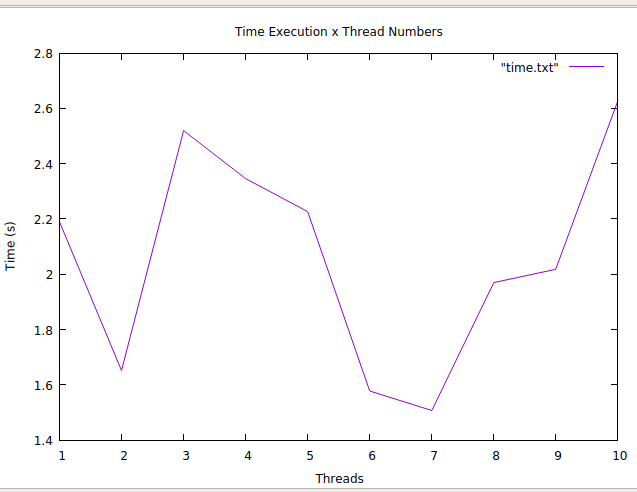

**Figura 1**: *1 a 10 threads*




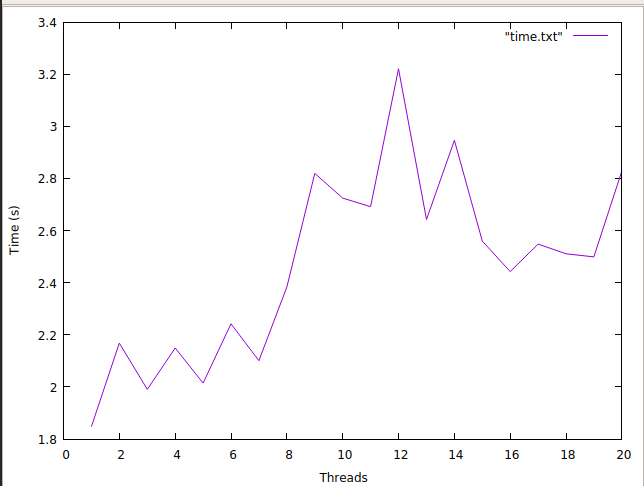




**Figura 2**: *1 a 20 threads*

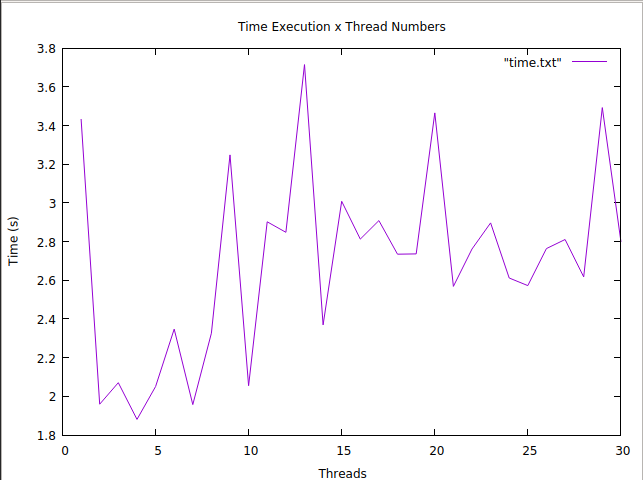

**Figura 3**: *1 a 30 threads*


### Session 3 - Prime Numbers

Nessa sessão trabalhou-se com a checagem se um dado número é primo ou não

#### Big prime

Nesse código realizou-se a paralelização de uma maneira diferente do primeiro código do Hands on 1 sessão 1, e próximo ao que foi feito no Hands On 1 sessão 2.

Realizou-se uma divisão da execução das atividades por threads de valor fixo para que realizassem as verificações por parte (pedaço) do maior número inteiro de 8 bits possível. Tendo como base o valor trazido nos exemplos de código, usamos 4 threads fixas para a aplicação do paralelismo nesse código.

In [2]:
%%writefile big_prime.c
#include <stdio.h>
#include <math.h>
#include <limits.h>
#include <omp.h>

typedef unsigned long long big_integer;
#define BIGGEST_INTEGER ULLONG_MAX

int is_prime(big_integer n)
{
  int result;
  big_integer sq_root, i;

  result = (n % 2 != 0 || n == 2);

  if (result)
  {
    sq_root = sqrt(n);
    
    omp_set_num_threads(4);
    #pragma omp parallel private(i)
    {
      int id = omp_get_thread_num();

      if(id == 0)
      {
        i = 3;
        while(result && i <= (big_integer)sq_root/4){
          result = n % i != 0;
          i += 2;
        }
      }
      if(id == 1)
      {
        i = (big_integer)sq_root/4;
        while(result && i <= 2*sq_root/4){
          result = n % i != 0;
          i += 2;
        }
      }
      if(id == 2)
      {
        i = 2*(big_integer)sq_root/4;
        while(result && i <= 3*sq_root/4){
          result = n % i != 0;
          i += 2;
        }
      }
      if(id == 3)
      {
        i = 3*(big_integer)sq_root/4;
        while(result && i <= sq_root){
          result = n % i != 0;
          i += 2;
        }
      }
    }
    
    // for (big_integer i = 3; result && i <= sq_root; i += 2)
    //   result = n % i != 0;
  }

  return result;
}

int main(int argc, char **argv)
{
  big_integer n;
  double t1, t2;
  t1 = omp_get_wtime();
  for (n = BIGGEST_INTEGER; !is_prime(n); n -= 2)
  {
  }
  t2 = omp_get_wtime();
  printf("Time execution: %lf\n", t2-t1);
  printf("%llu\n", n);

  return 0;
}

Writing big_prime.c


In [3]:
!gcc big_prime.c -o big_prime -fopenmp -lm
!./big_prime

Time execution: 13.983013
18446744073709551613


#### Count Primes

Similar ao problema anterior, nesse código trazemos a contagem de números primos existentes entre 3 e o maior inteiro de 8 bits.

A paralelização é parecida com a realizada no código anterior, entretanto, ao invés da contagem ser decrescente (como em big_prime), essa é crescente.

código

In [ ]:
%%writefile count_primes.c

In [ ]:
!gcc count_prime.c -o count_prime -fopenmp -lm
!OMP_NUM_THREADS=4 ./count_primes

In [ ]:
%%writefile script.sh
#!/bin/bash

for k in {1..6}
do
 printf "$k threads: "
 OMP_NUM_THREADS=$K ./count_prime
done

In [ ]:
!bash script.sh

# Conclusions

Foram adicionados alguns trechos de códigos que buscaram paralelizar problemas considerados "simples" visando reduzir o tempo de execução. Através disso, percebeu-se instabilidade quanto à quantidade de threads e o tempo de execução dos processos, em que, algumas vezes o mesmo código com os mesmos hiperparâmetros, quando executados mais de uma vez, não obtinham resultados similares. Levantando algumas questões,como: a execução em um PC com paralelização vai conseguir trazer o melhor resultado?. Ademais, a prática foi importante para trabalhar com os conceitos de paralelização e sincronicidade.

# References

[1] Coleman, T. G., Mesick, H. C., & Darby, R. L. (1977). Numerical integration. Annals of Biomedical Engineering, 5(4), 322–328. doi:10.1007/bf02367312 

[2] He, K., Sun, J., & Tang, X. (2013). Guided Image Filtering. IEEE Transactions on Pattern Analysis and Machine Intelligence, 35(6), 1397–1409. doi:10.1109/tpami.2012.213 